In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2
from matrix_factorization import Matrix_Factorization_V2

import seaborn as sns
import matplotlib.pylab as plt

# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -200

# VBD DATA

In [8]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']
def preprocess_data(raw_data='training-vbd-floor3.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json('training-vbd-floor3.json')
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

## Split train set & test set

In [9]:

training_data = rssi_dataset_df.sample(frac=0.9, random_state=10)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 225
No. of testing examples: 25


# MATRIX FACTORIZATION V2 

## Helper functions: get predict & test radiomap 

In [10]:
def get_one_beacon(dataset=training_data, beacon='Beacon00001'):
    beacon_data = dataset[['col','row',beacon]].copy()
    # rename columns
    beacon_data.rename(columns={beacon:'rssi'}, inplace=True)
    return beacon_data

def get_mf_model(training_data_single, testing_data_single):
    # prepare data
    rate_train = training_data_single.to_numpy()
    rate_test = testing_data_single.to_numpy()

    # # indices start from 0
    # rate_train[:, :2] -= 1
    # rate_test[:, :2] -= 1

    rs = Matrix_Factorization_V2(rate_train, K = 4, lam = 0.01, print_every = 100000, 
        learning_rate = 0.01, max_iter = 10000, user_based = 1)
    rs.fit()
    # evaluate on test data
    RMSE = rs.evaluate_RMSE(rate_test)
    print ('\nUser-based MF, RMSE test =', RMSE)

    return rs

def get_test_mtx(training_data_single, testing_data_single):
    # init test matrix
    n_rows = int(training_data_single.row.max())+1
    n_cols = int(training_data_single.col.max())+1
    radiomap_test = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
    radiomap_test[testing_data_single.row, testing_data_single.col] = testing_data_single.rssi

    return radiomap_test

## Generating RadioMap

In [11]:
from helper import plot_radiomap


User-based MF, RMSE test = 0.21851698298591937


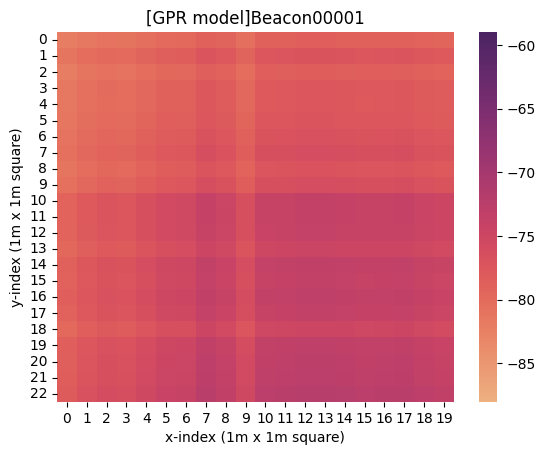


User-based MF, RMSE test = 0.23021266111539032


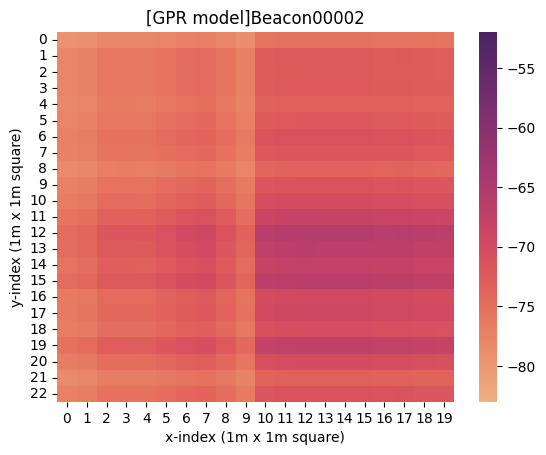


User-based MF, RMSE test = 0.22211287436795402


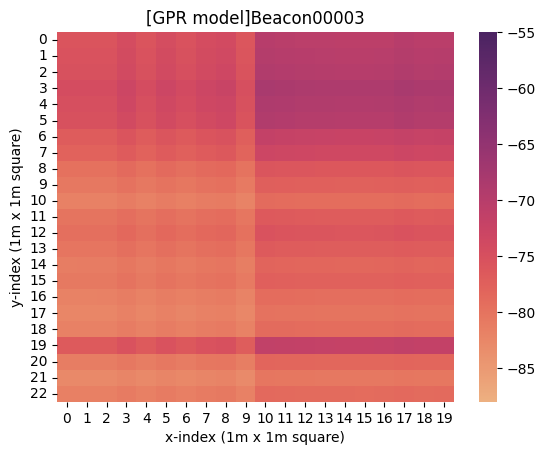


User-based MF, RMSE test = 0.20673546773149626


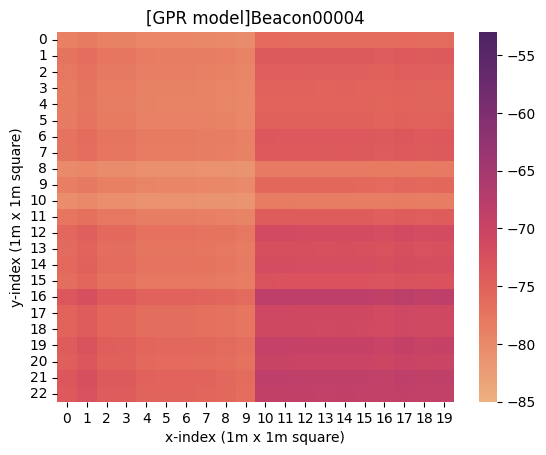


User-based MF, RMSE test = 0.2433240359620896


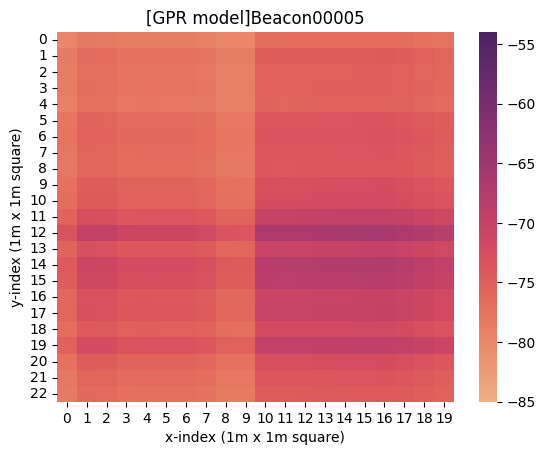


User-based MF, RMSE test = 0.2385412503486965


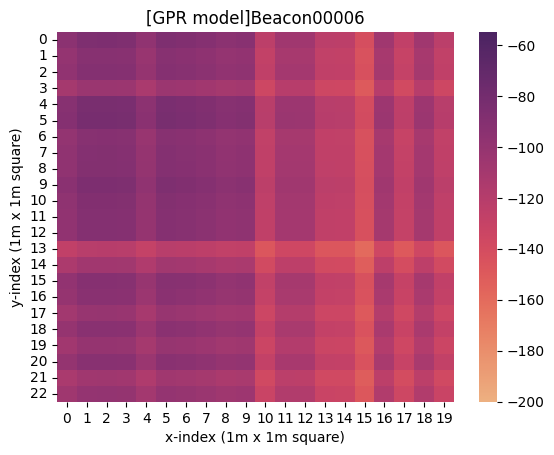

In [12]:
radiomaps = []
radiomaps_test = []
for beacon in beacons:
    training_data_single = get_one_beacon(dataset=training_data, beacon=beacon)
    testing_data_single = get_one_beacon(dataset=testing_data, beacon=beacon)
    rs = get_mf_model(training_data_single, testing_data_single)
    test_mtx = get_test_mtx(training_data_single, testing_data_single)
    # plot Raw & MF radiomap
    plot_radiomap(rs.get_pred_mtx(), rs.min_data, rs.max_data,beacon=beacon)
    # append radiomap for every beacon into list
    radiomaps.append(rs.get_pred_mtx().flatten())
    radiomaps_test.append(test_mtx.flatten())

## Build search space for indoor positioning

In [70]:
import helper

test data: [-64 -63 -71 -77 -69 -56]
test position (matrix idx): (1,8)
3 nearest neighbours (array idx): [29 39 28] [0.00161248 0.00214607 0.00223863]
3 nearest neighbours (matrix idx): ([[2 9]
 [3 9]
 [2 8]])
centroid cell: ([2.80399224 9.20857721])
error: 1.4840746008764574


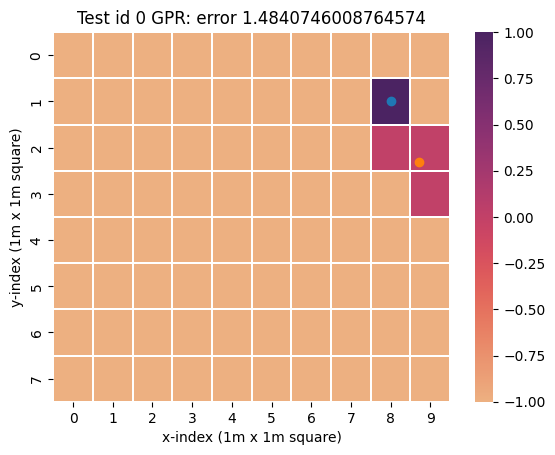

test data: [-64 -67 -66 -68 -58 -68]
test position (matrix idx): (0,5)
3 nearest neighbours (array idx): [14 12 11] [0.00071871 0.00092018 0.00102204]
3 nearest neighbours (matrix idx): ([[1 4]
 [1 2]
 [1 1]])
centroid cell: ([1.49999993 3.02199824])
error: 2.672170015761317


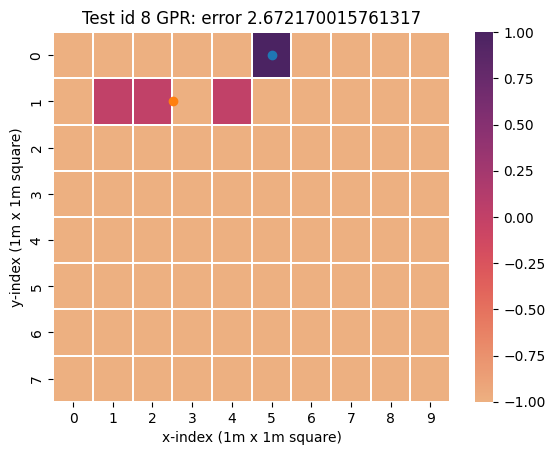

test data: [-65 -65 -64 -72 -56 -66]
test position (matrix idx): (0,6)
3 nearest neighbours (array idx): [14 15 17] [0.00167638 0.00192416 0.00197995]
3 nearest neighbours (matrix idx): ([[1 4]
 [1 5]
 [1 7]])
centroid cell: ([1.50000002 5.75510769])
error: 1.2469420986654014


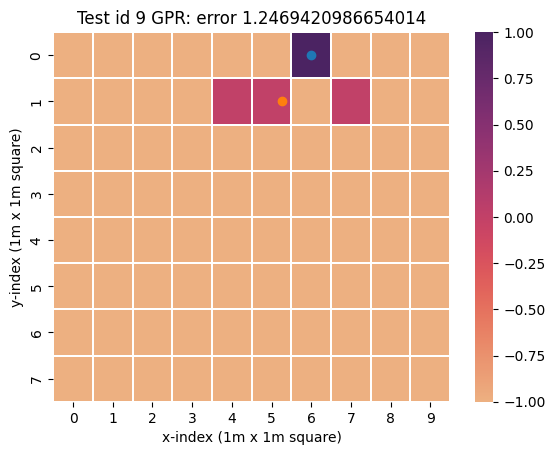

test data: [-69 -71 -73 -64 -65 -73]
test position (matrix idx): (1,2)
3 nearest neighbours (array idx): [10 11 12] [0.00027233 0.00036955 0.00043911]
3 nearest neighbours (matrix idx): ([[1 0]
 [1 1]
 [1 2]])
centroid cell: ([1.50000003 1.33887136])
error: 1.1611286427101122


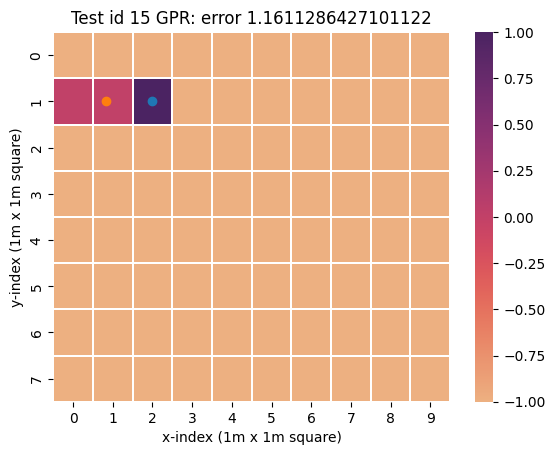

test data: [-62 -63 -68 -68 -66 -61]
test position (matrix idx): (2,6)
3 nearest neighbours (array idx): [29 28 37] [7.6472759e-05 1.7440319e-04 2.7179718e-04]
3 nearest neighbours (matrix idx): ([[2 9]
 [2 8]
 [3 7]])
centroid cell: ([2.66359623 8.91785258])
error: 2.4233808634437706


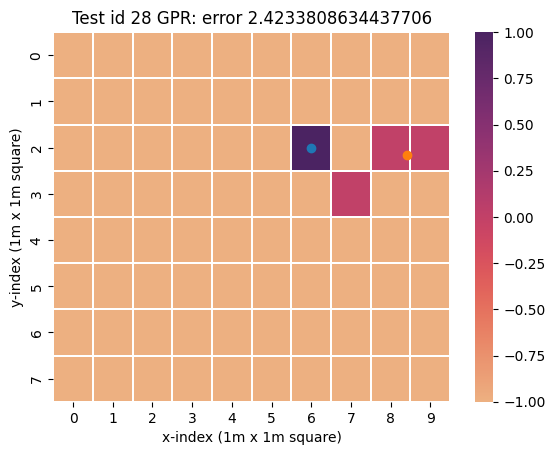

test data: [-66 -63 -66 -69 -66 -63]
test position (matrix idx): (2,7)
3 nearest neighbours (array idx): [28 29 27] [0.00026274 0.00028002 0.00034875]
3 nearest neighbours (matrix idx): ([[2 8]
 [2 9]
 [2 7]])
centroid cell: ([2.49999995 8.56869238])
error: 1.0686923794421734


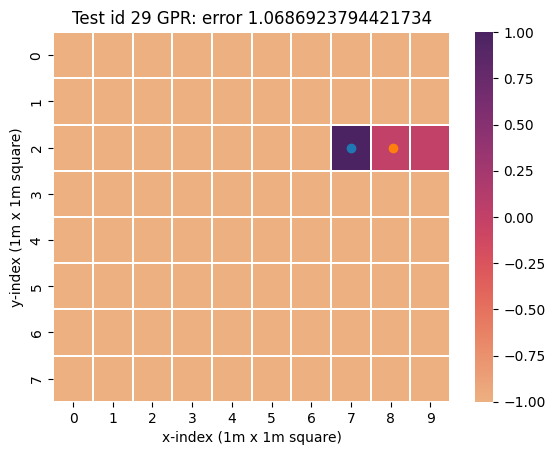

test data: [-67 -67 -67 -66 -71 -68]
test position (matrix idx): (6,2)
3 nearest neighbours (array idx): [34 33 52] [0.00039208 0.00044429 0.00050616]
3 nearest neighbours (matrix idx): ([[3 4]
 [3 3]
 [5 2]])
centroid cell: ([4.08305236 3.5848254 ])
error: 2.6492417862131195


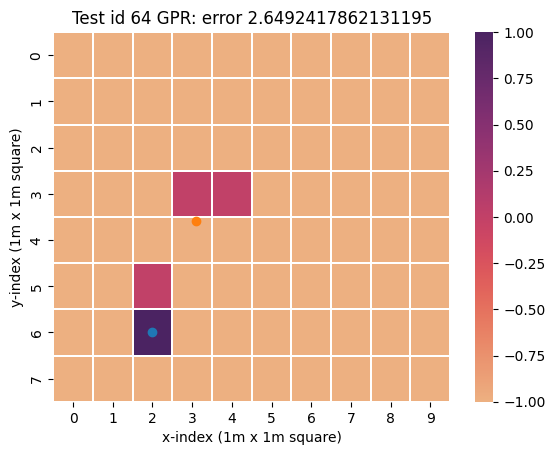

test data: [-67 -59 -70 -65 -75 -69]
test position (matrix idx): (7,2)
3 nearest neighbours (array idx): [73 71 70] [0.00056124 0.00061142 0.00067455]
3 nearest neighbours (matrix idx): ([[7 3]
 [7 1]
 [7 0]])
centroid cell: ([7.50000035 1.92472831])
error: 0.5752716908201679


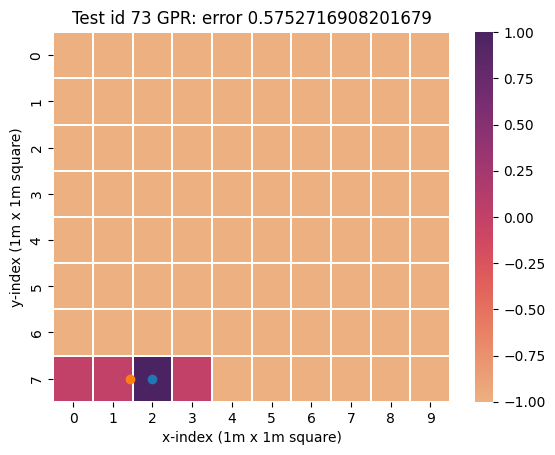

RMSE:  1.8238130423547525


In [87]:
helper.check_position_pred_accuracy(radiomaps=radiomaps, testing_data=testing_data)

In [86]:
len(testing_data)

8